In [ ]:
import torch
import torchvision
import itertools
import numpy as np
from IPython.display import clear_output
import torch.nn as nn
import seaborn as sns
from einops import rearrange
from tqdm import tqdm
from random import Random
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix, classification_report

Load the MNIST dataset

Normalizing the image


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])

Actual_train_dataset = torchvision.datasets.MNIST(root='./data',train=True,download = True,transform = transform)
Actual_test_dataset = torchvision.datasets.MNIST(root='./data',train = False,download = True,transform = transform)

In [ ]:
print(len(Actual_train_dataset))
print(len(Actual_test_dataset))

60000
10000


Define classes you want to sample

In [ ]:
classes_to_sample = [0,1,2]

sample 100 images from each class in the training set for the VIT

In [ ]:
train_samples = []
previous_train_indices = []
for cls in classes_to_sample:
  class_indices = [i for i,label in enumerate(Actual_train_dataset.targets) if label == cls]
  sampled_indices = np.random.choice(class_indices,100,replace = False)
  previous_train_indices.append(sampled_indices)
  # print(sampled_indices)
  sampled_images = torch.stack([Actual_train_dataset[i][0] for i in sampled_indices])
  train_samples.append(sampled_images)

train_samples = torch.cat(train_samples,dim=0)
# print(previous_train_indices)

sample 100 images from each class in the test set for the VIT


In [ ]:
test_samples=[]
previous_test_indices=[]
for cls in classes_to_sample:
  class_indices = [i for i,label in enumerate(Actual_test_dataset.targets) if label == cls]
  sampled_indices = np.random.choice(class_indices,100, replace = False)
  previous_test_indices.append(sampled_indices)
  sampled_images = torch.stack([Actual_test_dataset[i][0] for i in sampled_indices])
  test_samples.append(sampled_images)

# print(test_samples[0][0])
test_samples = torch.cat(test_samples,dim=0)
# print(len(test_samples))
# print(previous_test_indices)

Convert the datasets to pytorch TensorDatasets


In [ ]:
train_labels = torch.cat([torch.full((100,),i) for i in [0,1,2]])
test_labels = torch.cat([torch.full((100,),i) for i in [0,1,2]])

VIT_train_dataset = TensorDataset(train_samples,train_labels)
VIT_test_dataset = TensorDataset(test_samples,test_labels)

TO see the images


In [ ]:
print(len(VIT_train_dataset))
print(len(VIT_test_dataset))

300
300


In [ ]:
# def show_mnist_images(dataset,num_images=10):
#   plt.figure(figsize=(10,2))
#   for i in range(num_images):
#     image,label = dataset[i]
#     image = image.squeeze()
#     plt.subplot(1,num_images,i+1)
#     plt.imshow(image,cmap='gray')
#     plt.title(f'Label: {label}')
#     plt.axis('off')
#   plt.show()

# show_mnist_images(VIT_train_dataset,num_images=10)

DataLoader


In [ ]:
train_loader = DataLoader(VIT_train_dataset,batch_size=12,shuffle=True)
test_loader = DataLoader(VIT_test_dataset,batch_size=12,shuffle=False)

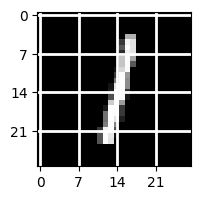

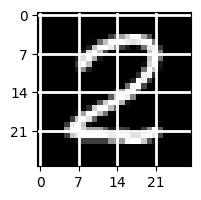

In [ ]:
def visualize_patches(img,patch_size):
  _,ax = plt.subplots(1,1,figsize=(2,2))
  img = img.squeeze(0)
  ax.imshow(img,cmap='gray')
  ax.set_xticks(range(0,img.shape[0],patch_size))
  ax.set_yticks(range(0,img.shape[1],patch_size))
  ax.grid(color='white',linestyle='-',linewidth=2)
  plt.show()

n_to_viuslize =0
patch_size=7
for image,_ in train_loader:
  visualize_patches(image[0],patch_size)
  n_to_viuslize+=1
  if(n_to_viuslize==2):
    break

#Hyperparameters


In [ ]:
img_size = 28
patch_size = 7
num_classes = 3
batch_size = 64

Vision Transformer


In [ ]:
class PatchEmbedding_conv(nn.Module):
  def __init__(self,img_size,patch_size,in_channels=1,embed_dim=128):
    super(PatchEmbedding_conv,self).__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels,embed_dim,kernel_size=patch_size,stride=patch_size)

  def forward(self,x):
    x = self.proj(x)
    x=rearrange(x,'b e h w -> b (h w) e')
    return x

patch_embedding = PatchEmbedding_conv(img_size,patch_size)
sample_image = next(iter(train_loader))[0][0].unsqueeze(0)
patches = patch_embedding(sample_image)
print(patches.shape)


torch.Size([1, 16, 128])


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape
        q = self.query(x).view(B, N, self.num_heads, self.head_dim)
        k = self.key(x).view(B, N, self.num_heads, self.head_dim)
        v = self.value(x).view(B, N, self.num_heads, self.head_dim)

        q, k, v = map(lambda t: rearrange(t, 'b n h d -> b h n d'), (q, k, v))

        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)

        attn = attn.softmax(dim=-1)
        # print(attn.shape)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.out(out)
        return out,attn

# Test Multi-Head Self-Attention
mhsa = MultiHeadSelfAttention(embed_dim=128, num_heads=8)
attn_output,attn = mhsa(patches)
# print(attn.shape)
print(attn_output.shape)  # Expected shape: (1, num_patches, embed_dim)


torch.Size([1, 16, 128])


In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0):
        super(TransformerEncoderBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mhsa = MultiHeadSelfAttention(embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        attn_out,attn=self.mhsa(self.norm1(x))
        x = x + self.dropout1(attn_out)
        x = x + self.dropout2(self.mlp(self.norm2(x)))
        return x

# Test Transformer Encoder Block
encoder_block = TransformerEncoderBlock(embed_dim=128, num_heads=8, mlp_dim=256)
encoded_output = encoder_block(attn_output)
print(encoded_output.shape)  # Expected shape: (1, num_patches, embed_dim)


torch.Size([1, 16, 128])


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=7, num_classes=3, embed_dim=128, depth=2, num_heads=8, mlp_dim=256,dropout=0):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding_conv(img_size, patch_size, embed_dim=embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.dropout = nn.Dropout(0.1)

        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim,dropout)
            for _ in range(depth)
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x,con=False):
        x = self.patch_embedding(x)
        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # print(x.shape)
        x += self.pos_embedding
        x = self.dropout(x)

        for encoder_block in self.encoder:
            x = encoder_block(x)

        if con:
          return x[:,0]
        x = self.mlp_head(x[:, 0])
        return x

# Test Vision Transformer
vit = VisionTransformer()
output = vit(sample_image)
print(output.shape)  # Expected shape: (batch_size, num_classes)


torch.Size([1, 3])


In [ ]:
from re import M
def train_model(model, train_loader, criterion, optimizer,schedular,num_epochs,num_batch_size):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
            optimizer.step()
            accuracy = labels.eq(F.softmax(outputs,dim=1).argmax(1)).sum().div(num_batch_size).mul(100)
            running_loss += loss.item()
            running_accuracy += accuracy.item()
        schedular.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        print(f"Epoch {epoch+1}/{num_epochs},Accuracy: {running_accuracy/len(train_loader)}")


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = (all_preds == all_labels).float().mean().item()
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(all_labels.numpy(), all_preds.numpy()))


Hperparameters

In [ ]:
learning_rate = 0.0001
num_epochs = 10
num_batches = 12
hidden_dim = 512
# embed_dim =

In [ ]:
model = VisionTransformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
schedular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

Train VIT

In [ ]:
train_model(model, train_loader, criterion, optimizer,schedular, num_epochs,num_batches)

Epoch 1/10, Loss: 1.1499717807769776
Epoch 1/10,Accuracy: 31.00000030517578
Epoch 2/10, Loss: 1.0811369013786316
Epoch 2/10,Accuracy: 40.0
Epoch 3/10, Loss: 1.0549595141410828
Epoch 3/10,Accuracy: 48.666666717529296
Epoch 4/10, Loss: 0.9593509793281555
Epoch 4/10,Accuracy: 63.00000015258789
Epoch 5/10, Loss: 0.6777983808517456
Epoch 5/10,Accuracy: 81.0
Epoch 6/10, Loss: 0.4007666563987732
Epoch 6/10,Accuracy: 87.66666564941406
Epoch 7/10, Loss: 0.262288773059845
Epoch 7/10,Accuracy: 89.33333435058594
Epoch 8/10, Loss: 0.20244837746024133
Epoch 8/10,Accuracy: 92.00000061035156
Epoch 9/10, Loss: 0.14570129454135894
Epoch 9/10,Accuracy: 95.66666748046875
Epoch 10/10, Loss: 0.12458824388682842
Epoch 10/10,Accuracy: 95.00000183105469


In [ ]:
torch.save(model.state_dict(), "vit_model.pth")

Printing model parameters


In [ ]:
# for p in model.parameters():
#   if p.grad is not None:
#     print(p.grad.data.abs().mean())

Evaluation VIT and making confusion Matrix

Classification Accuracy: 94.33%


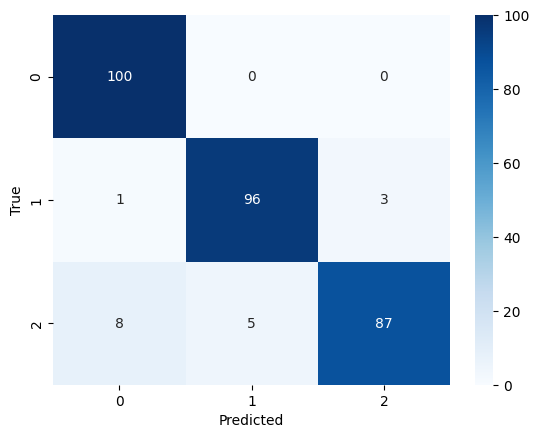

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       100
           1       0.95      0.96      0.96       100
           2       0.97      0.87      0.92       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



In [ ]:
evaluate_model(model, test_loader)

ViT with Regularization and Data Augmentation

1. Regularization


*   Weight decay
*   Dropout

2. Data Augmentation


*   MixUp
*   RandAugment

---





In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 10,
    "hidden_dim": 256,
    "num_heads": 4,
    "hidden_embedding_size": 256,
    "dropout": 0.2,
    "stochastic_depth_probability": 0.2,
}

In [ ]:
model = VisionTransformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.0001)
schedular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

In [ ]:
def mixup_data(x, y, alpha=1.0):
  if alpha > 0:
    lam = torch.distributions.Beta(alpha, alpha).sample()
  else:
    lam = 1.0
  batch_size = x.size(0)
  index = torch.randperm(batch_size)

  mixed_x = lam * x + (1 - lam) * x[index, :]
  mixed_y = lam * y + (1 - lam) * y[index]
  return mixed_x[0], mixed_y.long()[0]

In [ ]:
def rand_augment(image, num_ops=2, magnitude=9):
  augmentations = [
    torchvision.transforms.RandomRotation(degrees=(0, magnitude * 10)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomResizedCrop(size=image.shape[-2:], scale=(0.8, 1.0)),
    torchvision.transforms.ColorJitter(brightness=magnitude/10, contrast=magnitude/10),
    torchvision.transforms.RandomAffine(degrees=(0, 0), translate=(magnitude/20, magnitude/20)),
  ]

  transform_list = torch.randperm(len(augmentations))[:num_ops].tolist()

  for i in transform_list:
    image = augmentations[i](image)

  return image

In [ ]:
def train_aug(Network,
              number_of_epoch,
              dataloader,
              criterion,
              optimizer,
              hyperparameters,
              ):
    Network.train()

    # _save_hyperparameters_to_pdf(hyperparameters,pdf)

    for epoch in range(number_of_epoch):
      running_loss = 0.0
      all_preds = []
      all_labels = []
      for data, label in dataloader:
        if torch.rand(1).item() > 0.5:
          data, label = mixup_data(data.unsqueeze(0), label.unsqueeze(0))
        else:
          data = rand_augment(data)

        optimizer.zero_grad()
        outputs = Network(data)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds)
        all_labels.append(label)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
      all_preds = torch.cat(all_preds)
      all_labels = torch.cat(all_labels)
      accuracy = (all_preds == all_labels).float().mean().item()

      clear_output(wait=True)
      print(f"Epoch {epoch+1} Loss: {running_loss/len(dataloader)} Accuracy: {accuracy* 100:.2f}%")


In [ ]:
train_aug(Network=model,
          number_of_epoch=hyperparameters['num_epochs'],
          dataloader=train_loader,
          criterion = criterion,
          optimizer = optimizer,
          hyperparameters=hyperparameters
          )

Epoch 10 Loss: 0.4763642412424087 Accuracy: 81.00%


In [ ]:
def evaluate( Network,
              dataloader,
              ):
  Network.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for data, label in dataloader:
      outputs = Network(data)
      _, preds = torch.max(outputs, 1)
      all_preds.append(preds)
      all_labels.append(label)
  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)

  accuracy = (all_preds == all_labels).float().mean().item()
  print(f"Classification Accuracy: {accuracy * 100:.2f}%")

  matrix = confusion_matrix(all_labels.numpy(), all_preds.numpy())
  fig, ax = plt.subplots()
  sns.heatmap(matrix, annot=True, fmt='d', cmap='jet', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2], ax=ax)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  ax.set_title(f'Confusion Matrix - Accuracy: {accuracy * 100:.2f}%')
  # pdf.savefig(fig)
  plt.close(fig)

  classification_rep = classification_report(all_labels.numpy(), all_preds.numpy())
  # self._save_text_to_pdf("Classification Report", classification_rep)


In [ ]:
evaluate(Network=model,
         dataloader = test_loader)

Classification Accuracy: 92.67%


Contrastive LOSS

In [ ]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,out_1, out_2, label):
    distance = torch.nn.functional.pairwise_distance(out_1,out_2)
    loss = torch.mean((1-label)*torch.pow(distance,2) + label*torch.pow(torch.clamp(1 - distance, min=0.0), 2))
    return loss

In [ ]:
model = VisionTransformer()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.0001)
schedular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

In [ ]:
import random

In [ ]:
def train_con(Network,
                number_of_epoch,
                dataloader,
                criterion,
                optimizer):
    Network.train()

    for epoch in range(number_of_epoch):
      running_loss = 0.0
      for data, _ in dataloader:
        data2 = rand_augment(data,num_ops=1)

        data_pairs = list(itertools.product(data, data2))
        data1 = torch.stack([pair[0] for pair in data_pairs])
        data2 = torch.stack([pair[1] for pair in data_pairs])

        label = torch.ones(data1.size(0))
        batch_size = data.size(0)
        for i in range(batch_size):
          label[i * batch_size + i] = 0

        similar_indices = (label == 0).nonzero(as_tuple=True)[0]
        dissimilar_indices = (label == 1).nonzero(as_tuple=True)[0]

        sampled_dissimilar_indices = random.sample(dissimilar_indices.tolist(), len(similar_indices))
        indices = torch.tensor(similar_indices.tolist() + sampled_dissimilar_indices).to(data.device)

        data1 = data1[indices]
        data2 = data2[indices]
        label = label[indices]

        optimizer.zero_grad()
        outputs1 = Network(data1,con = True)
        outputs2 = Network(data2,con = True)

        loss = criterion(outputs1, outputs2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      # clear_output(wait=True)
      print(f"Epoch {epoch+1} Loss: {running_loss/len(dataloader)}")

In [ ]:
train_con(model,2,train_loader,criterion,optimizer)

Epoch 1 Loss: 21.017184219360352
Epoch 2 Loss: 19.72689147949219


SWIM DATASET

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 653.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.5 MB/s eta 0:00:00


In [ ]:
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [ ]:
previous_train_indices = np.array(previous_train_indices)
previous_test_indices = np.array(previous_test_indices)
# print(previous_train_indices)

In [ ]:
new_train_indices = {0:[],1:[],2:[]}
new_test_indices = {0:[],1:[],2:[]}

In [ ]:
for i,(image,label) in enumerate(Actual_train_dataset):
  if label in [0,1,2] and i not in previous_train_indices:
    new_train_indices[label].append(i)

In [ ]:
for i,(image,label) in enumerate(Actual_test_dataset):
  if label in [0,1,2] and i not in previous_train_indices:
    new_test_indices[label].append(i)

In [ ]:
selected_train_indices = []
selected_test_indices = []

for cls in classes_to_sample:
  selected_train_indices.extend(np.random.choice(new_train_indices[cls],100,replace=False))
  selected_test_indices.extend(np.random.choice(new_test_indices[cls],100,replace=False))

In [ ]:
Swim_train_samples = torch.utils.data.Subset(Actual_train_dataset,selected_train_indices)
Swim_test_samples = torch.utils.data.Subset(Actual_test_dataset,selected_test_indices)

In [ ]:
print(len(Swim_train_samples))

300


In [ ]:
Swim_train_loader = torch.utils.data.DataLoader(Swim_train_samples,batch_size=12,shuffle=True)
Swim_test_loader = torch.utils.data.DataLoader(Swim_test_samples,batch_size=12,shuffle=True)

In [ ]:
def window_partition(x, window_size):

    B, H, W, C = x.shape
    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size

    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))

    H_padded, W_padded = x.shape[1], x.shape[2]

    x = x.view(B, H_padded // window_size, window_size, W_padded // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)

    return windows


In [ ]:

class PatchEmbed(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_chans=1, embed_dim=128, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x


In [ ]:

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    x = x.view(B, H, W, -1)

    return x


In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act_layer = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_layer(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [ ]:

class WindowAttention(nn.Module):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
        coords_flatten = torch.flatten(coords, 1)

        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)

        self.register_buffer('relative_position_index', relative_position_index)

        # Attention
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x, mask=None):
        B_, N, C = x.shape

        qkv = self.qkv(x)

        qkv = qkv.reshape(B_, N, 3, self.num_heads, C // self.num_heads)

        qkv = qkv.permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale

        attn = (q @ k.transpose(-2, -1))
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1],  -1
        )

        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)

            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


In [ ]:
class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L,C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]

        x = torch.cat([x0, x1, x2, x3], -1)

        x = x.view(B, -1, 4 * C)

        x = self.norm(x)
        x = self.reduction(x)

        return x



In [ ]:
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = min(window_size, min(input_resolution))  # Ensure window_size is valid
        self.shift_size = shift_size if shift_size < self.window_size else 0  # Ensure shift_size is within bounds
        self.mlp_ratio = mlp_ratio

        assert 0 <= self.shift_size < self.window_size, "shift_size must be in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        # Calculate attention mask for SW-MSA
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # Cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # Partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # Merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        # Reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


In [ ]:
class SimpleSwinTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_chans=1, num_classes=3,
                 embed_dim=96, depths=[2, 2], num_heads=[3, 6], window_size=7,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # Split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic Depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] # stochastic depth decay rule

        # Build Swin Transformer layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=(
                    patches_resolution[0] // (2 ** i_layer), # After patch-merging layer, patches_resolution(H, W) is halved
                    patches_resolution[1] // (2 ** i_layer),
                ),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None, # No patch merging at the last stage
            )
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Classification Head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        x = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x) # (B, L, C)
        x = self.avgpool(x.transpose(1, 2)) # (B, C, 1)
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [ ]:

class BasicLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # Build  Swin-Transformer Blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio = mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer
                                )
            for i in range(depth)
        ])


        # Patch Merging Layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None


    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)

        if self.downsample is not None:
            x = self.downsample(x)

        return x


Stage 1


In [ ]:
stage_1 = BasicLayer(dim=128, input_resolution=(4, 4), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(patches)
print(output.shape)
output

torch.Size([1, 16, 128])


tensor([[[-0.4190, -0.7563, -0.8105,  ...,  0.6297,  0.4798, -0.5649],
         [-0.3977, -0.8002, -0.7496,  ...,  0.6237,  0.4607, -0.5449],
         [-1.3915, -0.9089, -0.7139,  ...,  0.1024,  0.6572, -0.4055],
         ...,
         [ 0.5752,  0.2125, -0.3761,  ...,  0.5891, -0.0957, -0.3118],
         [ 0.0665, -0.3091, -0.7166,  ...,  1.0115,  0.1487, -0.6597],
         [-0.3602, -0.8059, -0.9385,  ...,  0.8065,  0.5675, -0.5291]]],
       grad_fn=<AddBackward0>)

Knowledge Distillation

In [ ]:
# Define the KL Divergence loss with temperature scaling
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature

    def forward(self, student_outputs, teacher_outputs):
        soft_teacher_outputs = F.softmax(teacher_outputs / self.temperature, dim=1)
        soft_student_outputs = F.log_softmax(student_outputs / self.temperature, dim=1)
        loss = F.kl_div(soft_student_outputs, soft_teacher_outputs, reduction='batchmean')
        return loss

# Instantiate the distillation loss
distillation_loss = DistillationLoss(temperature=4)

Train Swim

In [ ]:
# Example instantiation
swin_model = SimpleSwinTransformer(img_size=28, patch_size=4, in_chans=1, num_classes=3,
                                   embed_dim=96, depths=[2, 2], num_heads=[3, 6], window_size=7)


In [ ]:
import torch

# Define the Swin Transformer model (make sure this matches the final model you implemented)
swin_model = SimpleSwinTransformer(
    img_size=28,
    patch_size=2,
    in_chans=1,
    num_classes=3,
    embed_dim=96,
    depths=[2, 2],
    num_heads=[3, 6],
    window_size=7
)

# Create a dummy input tensor
# Simulate a batch of 2 images, each with 1 channel, and size 28x28
dummy_input = torch.randn(2, 1, 28, 28)

# Pass the dummy input through the model
output = swin_model(dummy_input)

# Print out the shape of the output tensor
print("Output shape:", output.shape)


Output shape: torch.Size([2, 3])


In [ ]:


# Assume vit_model is your pre-trained Vision Transformer model
vit_model = VisionTransformer()  # example configuration
vit_model.load_state_dict(torch.load("/content/vit_model.pth"))  # Load pre-trained ViT weights
vit_model.eval()

# Training settings
num_epochs = 30
learning_rate = 0.0001  # Example learning rate
optimizer = optim.Adam(swin_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    swin_model.train()
    running_loss = 0.0
    for images, _ in Swim_train_loader:  # Ground truth labels are not used
        optimizer.zero_grad()

        # Get teacher model predictions
        with torch.no_grad():
            teacher_outputs = vit_model(images)

        # Get student model predictions
        student_outputs = swin_model(images)

        # Compute distillation loss
        loss = distillation_loss(student_outputs, teacher_outputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


<ipython-input-249-a17b3ebc4fc1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("/content/vit_model.pth"))  # Load pre-trained ViT wei

Epoch 1/30, Loss: 0.05375007566064596
Epoch 2/30, Loss: 0.048219986353069545
Epoch 3/30, Loss: 0.03748925087973475
Epoch 4/30, Loss: 0.034500099327415226
Epoch 5/30, Loss: 0.0327657494880259
Epoch 6/30, Loss: 0.053005581311881544
Epoch 7/30, Loss: 0.04563612747937441
Epoch 8/30, Loss: 0.048875913638621565
Epoch 9/30, Loss: 0.040633688289672135
Epoch 10/30, Loss: 0.03297023698687553
Epoch 11/30, Loss: 0.03956006467342377
Epoch 12/30, Loss: 0.03692299088463187
Epoch 13/30, Loss: 0.02984450859948993
Epoch 14/30, Loss: 0.03063065208494663
Epoch 15/30, Loss: 0.02712597830221057
Epoch 16/30, Loss: 0.03464750539511442
Epoch 17/30, Loss: 0.03307199776172638
Epoch 18/30, Loss: 0.03254819005727768
Epoch 19/30, Loss: 0.02659903798252344
Epoch 20/30, Loss: 0.033464576583355665
Epoch 21/30, Loss: 0.029151382744312285
Epoch 22/30, Loss: 0.04114882891997695
Epoch 23/30, Loss: 0.03273942470550537
Epoch 24/30, Loss: 0.03030054096132517
Epoch 25/30, Loss: 0.023956729490309955
Epoch 26/30, Loss: 0.025824

Evaluation SWIM

Classification Accuracy: 92.67%


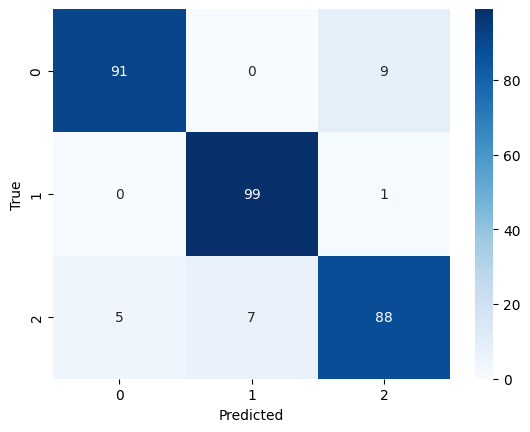

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       100
           1       0.93      0.99      0.96       100
           2       0.90      0.88      0.89       100

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in Swim_test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = (all_preds == all_labels).float().mean().item()
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print(classification_report(all_labels.numpy(), all_preds.numpy()))

# Evaluate Swin model on the test set
evaluate_model(swin_model, test_loader)
